#Разработка сверточной нейронной сети с использованием PyTorch

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import time
from time import perf_counter
import sys

from matplotlib import pyplot as plt
import numpy as np

Загрузка датасета и определение корректности его загрузки

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:08<00:00, 21013075.95it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
print('Number of train samples: {}'.format(len(trainset)))

print('Number of test samples: {}'.format(len(testset)))


Number of train samples: 50000
Number of test samples: 10000


torch.Size([3, 32, 32])
truck


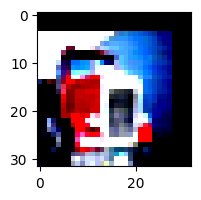

deer


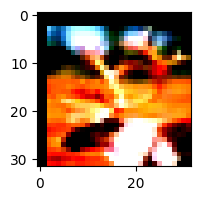

bird


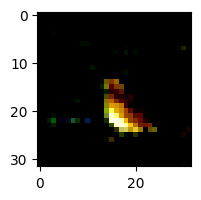

frog


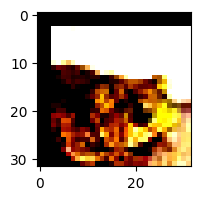

In [5]:
def image_show(image_data):
    np_image = image_data.numpy()
    np_image = np.transpose(np_image, (1,2,0))
    plt.figure(figsize = (2,2))
    plt.imshow(np_image)
    plt.show()

data_iter = iter(trainloader)
images,labels = next(data_iter)
img_data = images[0]
print(img_data.shape)
classes = trainset.classes
for i in range(1, 5):
    print(classes[labels[i].item()])
    image_show(images[i])

torch.Size([3, 32, 32])
ship


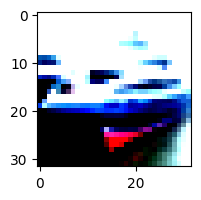

ship


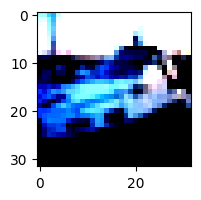

airplane


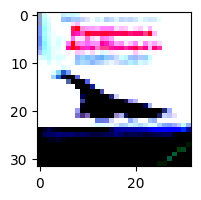

frog


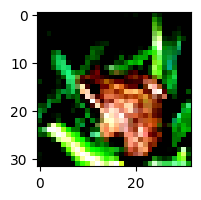

In [6]:
data_iter = iter(testloader)
images,labels = next(data_iter)
img_data = images[0]
print(img_data.shape)
for i in range(1, 5):
    print(classes[labels[i].item()])
    image_show(images[i])

Реализация сети SENet

In [7]:
class PreActBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)
            )

        self.fc1 = nn.Conv2d(planes, planes//16, kernel_size=1)
        self.fc2 = nn.Conv2d(planes//16, planes, kernel_size=1)

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))

        w = F.avg_pool2d(out, out.size(2))
        w = F.relu(self.fc1(w))
        w = F.sigmoid(self.fc2(w))
        out = out * w
        out += shortcut
        return out


class SENet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(SENet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block,  64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [20]:
loss_func = torch.nn.CrossEntropyLoss()
model = SENet(PreActBlock, [2,2,2,2])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

def current_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

Обучение

In [21]:
for epoch in range(30):
    loss_list = []
    acc_list = []
    time_one = perf_counter()
    for batch_idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss_list.append(loss)
        acc_list.append(current_accuracy(outputs, labels))
        loss.backward()
        optimizer.step()

    time_two = perf_counter()
    time = time_two-time_one
    print('Epoch {}: loss = {}, acc = {}, time = {}'.format(epoch, torch.stack(loss_list).mean(), torch.stack(acc_list).mean(), time))

Epoch 0: loss = 1.4901835918426514, acc = 0.44779011607170105, time = 49.0372655580004
Epoch 1: loss = 1.0020959377288818, acc = 0.6396939158439636, time = 48.61668350800028
Epoch 2: loss = 0.7754130363464355, acc = 0.7258951663970947, time = 48.56622240999968
Epoch 3: loss = 0.6414339542388916, acc = 0.7777013778686523, time = 48.29105559399977
Epoch 4: loss = 0.5618970394134521, acc = 0.8056145906448364, time = 48.26479252199988
Epoch 5: loss = 0.4991190731525421, acc = 0.8284407258033752, time = 48.433680049999566
Epoch 6: loss = 0.4473845362663269, acc = 0.8449088931083679, time = 48.75707484299892
Epoch 7: loss = 0.41248342394828796, acc = 0.8567814826965332, time = 48.31345264899937
Epoch 8: loss = 0.37768399715423584, acc = 0.8699408769607544, time = 48.25014538399955
Epoch 9: loss = 0.3478020131587982, acc = 0.87941974401474, time = 48.30195188899961
Epoch 10: loss = 0.3314482867717743, acc = 0.8863730430603027, time = 48.41648407899993
Epoch 11: loss = 0.3051176965236664, acc 

In [22]:
loss_list_test = []
acc_list_test = []
for batch_idx, (images, labels) in enumerate(testloader):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_func(outputs, labels)
    loss_list.append(loss)
    acc_list.append(current_accuracy(outputs, labels))
    loss.backward()
    optimizer.step()

print('Test loss = {}, Test acc = {}'.format(torch.stack(loss_list).mean(), torch.stack(acc_list).mean()))

Test loss = 0.1816520094871521, Test acc = 0.9372219443321228
